In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from random import shuffle

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [52]:
(_, y_train), (_, y_test) = tf.keras.datasets.mnist.load_data()

In [54]:
x_train64.shape

(60000, 64, 64, 1)

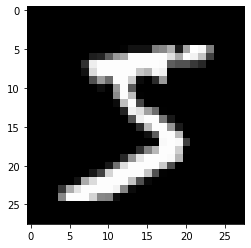

In [16]:
plt.imshow(x_train[0], cmap="gray")

In [17]:
def normalise_matrix(dataset):
    dataset = (dataset/255)*2 - 1
    return dataset

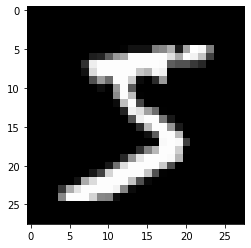

In [18]:
x_train = normalise_matrix(x_train)
x_test = normalise_matrix(x_test) 
plt.imshow(x_train[0], cmap="gray")

In [19]:
def one_hot_encoder(labels):
    enc = preprocessing.OneHotEncoder(categories="auto")
    enc.fit(labels.reshape(-1, 1))
    return enc.transform(labels.reshape(-1, 1)).toarray()

In [20]:
y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)

In [21]:
y_train = np.zeros((60000, 2))
y_train[:, 1] =  1

y_test = np.zeros((10000, 2))
y_test[:, 1] =  1

In [22]:
y_train = y_train.reshape(60000, 1, 2)
y_test = y_test.reshape(10000, 1, 2)

In [23]:
x_test.shape

(10000, 28, 28)

In [24]:
from skimage.transform import resize

x_train64 = x_train.tolist() 

for i, image in enumerate(x_train):
    x_train64[i] = resize(image, (64, 64)).reshape(64, 64, 1)

In [25]:
len(x_train64)

60000

In [26]:
x_test64 = x_test.tolist() 

for i, image in enumerate(x_test):
    x_test64[i] = resize(image, (64, 64)).reshape(64, 64,1)

In [27]:
x_train64 = np.asarray(x_train64)
x_test64 = np.asarray(x_test64)

In [28]:
noise_train = np.random.rand(10000, 64, 64, 1) * 2 - 1
noise_test = np.random.rand(5000, 64, 64, 1) * 2 - 1

In [29]:
# x_train64 = np.append(x_train64, noise_train, axis=0)
# x_test64 = np.append(x_test64, noise_test, axis=0)

In [48]:
x_train64.shape

(60000, 64, 64, 1)

In [31]:
y_train_noise = np.zeros((10000, 2))
y_train_noise[:, 0] =  1

y_test_noise = np.zeros((5000, 2))
y_test_noise[:, 0] =  1

In [32]:
# y_train_noise = y_train_noise.reshape(10000, 1, 2)
# y_test_noise = y_test_noise.reshape(5000, 1, 2)

In [33]:
# y_train = np.append(y_train, y_train_noise, axis=0)
# y_test = np.append(y_test, y_test_noise, axis=0)

In [42]:
from tensorflow.contrib.layers import flatten

def DCGAN_discriminator(x):
    # Hyperparameters to be added
    mu = 0
    sigma = 0.1
    
    # Discriminator
    
    # Layer 1: Convolutional. (Random) Input = 64x64x1. Output = 33x33x128.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [32, 32, 1, 128], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(128))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b
    
    # Batch Normalisation
    conv1 = tf.layers.batch_normalization(conv1)
    
    # Activation layer
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. (Random) Input = 33x33x128. Output = 18x18x256.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [16, 16, 128, 256], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(256))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    
    # Batch Normalisation
    conv2 = tf.layers.batch_normalization(conv2)
    
    # Activation layer
    conv2 = tf.nn.relu(conv2)
    
    # Layer 3: Convolutional. (Random) Input = 18x18x256. Output = 11x11x512.
    conv3_w = tf.Variable(tf.truncated_normal(shape = [8, 8, 256, 512], mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(512))
    conv3 = tf.nn.conv2d(conv2, conv3_w, strides = [1,1,1,1], padding = 'VALID') + conv3_b
    
    # Batch Normalisation
    conv3 = tf.layers.batch_normalization(conv3)
    
    # Activation layer
    conv3 = tf.nn.relu(conv3)

    # Layer 4: Convolutional. (Random) Input = 11x11x512. Output = 8x8x1024.
    conv4_w = tf.Variable(tf.truncated_normal(shape = [4, 4, 512, 1024], mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(1024))
    conv4 = tf.nn.conv2d(conv3, conv4_w, strides = [1,1,1,1], padding = 'VALID') + conv4_b
    
    # Batch Normalisation
    conv4 = tf.layers.batch_normalization(conv4)
    
    # Activation layer
    conv4 = tf.nn.relu(conv4)
    
    conv4 = flatten(conv4)
    
    conv5_w = tf.Variable(tf.truncated_normal(shape = (65536, 2), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(2))
    logits = tf.matmul(conv4, conv5_w) + conv5_b
    
#     logits = flatten(conv5)
    out = tf.sigmoid(logits)
        
    return out, logits

In [55]:
y_train.shape

(60000,)

In [56]:
x = tf.placeholder(tf.float32, (None, 64, 64, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,2)

In [57]:
rate = 0.001

_, logits = DCGAN_discriminator(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)  
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.AdamOptimizer(learning_rate=rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [58]:
predictions_operation = tf.argmax(tf.nn.softmax(logits), 1)
correct_prediction = tf.equal(predictions_operation, tf.argmax(y_train, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x: batch_x, y: batch_y})
        
        all_predictions = np.hstack((all_predictions, predictions))
        total_accuracy += (accuracy * len(batch_x))
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions

In [59]:
EPOCHS = 3
BATCH_SIZE = 100

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train64)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        np.random.shuffle(x_train64)
        np.random.shuffle(y_train)
         
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train64[offset:end], y_train[offset:end]
            print("Running session")
            print(batch_x.shape)
            print(batch_y.shape)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, validation_predictions = evaluate(x_test64, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

Running session
(100, 64, 64, 1)
(100,)
Running session
(100, 64, 64, 1)
(100,)
Running session
(100, 64, 64, 1)
(100,)


KeyboardInterrupt: 

In [ ]:
def DCGAN_generator(x):
    # Hyperparameters to be added
    mu = 0
    sigma = 0.1
    
    # Input = 1x100
    input_vec = x.reshape(10, 10, 1)
    
    # Generator
    
    # Layer 1: Transpos Convolutional. (Random) Input = 10x10x1
    conv1_w = tf.Variable(tf.truncated_normal(shape = [4, 4, 1, 1024], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(1024))
    conv1 = tf.nn.conv2d_transpose(input_vec, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b
    
    # Batch Normalisation
    conv1 = tf.layers.batch_normalization(conv1)
    
    # Activation layer
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2
    conv2_w = tf.Variable(tf.truncated_normal(shape = [8, 8, 1, 512], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(512))
    conv2 = tf.nn.conv2d_transpose(conv1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    
    # Batch Normalisation
    conv2 = tf.layers.batch_normalization(conv2)
    
    # Activation layer
    conv2 = tf.nn.relu(conv2)
    
    # Layer 3
    conv3_w = tf.Variable(tf.truncated_normal(shape = [16, 16, 1, 256], mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(256))
    conv3 = tf.nn.conv2d_transpose(conv2, conv3_w, strides = [1,1,1,1], padding = 'VALID') + conv3_b
    
    # Batch Normalisation
    conv3 = tf.layers.batch_normalization(conv3)
    
    # Activation layer
    conv3 = tf.nn.relu(conv3)
    
    # Layer 4
    conv4_w = tf.Variable(tf.truncated_normal(shape = [32, 32, 1, 128], mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(128))
    conv4 = tf.nn.conv2d_transpose(conv3, conv4_w, strides = [1,1,1,1], padding = 'VALID') + conv4_b
    
    # Batch Normalisation
    conv4 = tf.layers.batch_normalization(conv4)
    
    # Activation layer
    conv4 = tf.nn.relu(conv4)
    
    # Layer 5
    conv5_w = tf.Variable(tf.truncated_normal(shape = [64, 64, 1, 1], mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(1))
    conv5 = tf.nn.conv2d_transpose(conv4, conv5_w, strides = [1,1,1,1], padding = 'VALID') + conv5_b
    
    # Activation layer
    conv5 = tf.nn.tanh(conv5)
    
    
    return out, logits